## Import Libraries

In [42]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import hashlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from flask import Flask, render_template, request, jsonify, send_from_directory
from keras.models import load_model
from keras.models import save_model
import io
from tensorflow.keras.models import load_model
from werkzeug.utils import secure_filename
from threading import Thread

## Define paths

In [43]:
real_images_path = 'dataset/train/REAL'
fake_images_path = 'dataset/train/FAKE'
real_test_path = 'dataset/test/REAL'
fake_test_path = 'dataset/test/FAKE'

## Load Images from Folders

In [44]:
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:
            img = Image.open(img_path)
            img = img.resize((128, 128))
            img = np.array(img)
            images.append([img, label])
        except Exception as e:
            print(f"Error loading image {filename}: {e}")
    return images

### Convert to DataFrame

####  1. Train data

In [45]:
real_images = load_images_from_folder(real_images_path, label=0)  # Label 0 for real
fake_images = load_images_from_folder(fake_images_path, label=1)  # Label 1 for fake

# Combine fake and real
all_images = real_images + fake_images

# Convert to df
df = pd.DataFrame(all_images, columns=['image', 'label'])

print(df.head())

                                               image  label
0  [[[174, 175, 187], [173, 173, 186], [169, 169,...      0
1  [[[167, 179, 191], [168, 180, 192], [168, 180,...      0
2  [[[152, 197, 102], [149, 195, 99], [143, 188, ...      0
3  [[[131, 126, 122], [130, 125, 121], [127, 123,...      0
4  [[[37, 35, 12], [37, 35, 12], [37, 35, 12], [3...      0


In [46]:
df.tail(10)

,image,label
99990,"[[[235, 233, 234], [235, 233, 234], [235, 233,...",1
99991,"[[[17, 14, 27], [16, 14, 25], [16, 14, 24], [1...",1
99992,"[[[48, 66, 19], [49, 66, 20], [51, 68, 22], [5...",1
99993,"[[[113, 73, 47], [114, 75, 49], [119, 80, 53],...",1
99994,"[[[11, 0, 18], [11, 0, 17], [11, 0, 17], [11, ...",1
99995,"[[[0, 0, 0], [0, 0, 0], [7, 7, 5], [21, 21, 19...",1
99996,"[[[6, 17, 0], [6, 17, 0], [6, 17, 0], [6, 17, ...",1
99997,"[[[81, 79, 80], [81, 79, 80], [81, 79, 80], [8...",1
99998,"[[[36, 45, 0], [37, 45, 0], [37, 45, 0], [38, ...",1
99999,"[[[164, 162, 163], [164, 162, 163], [164, 162,...",1


#### 2. Test data

In [47]:
real_test_images = load_images_from_folder(real_test_path, label=0)  # Label 0 for real
fake_test_images = load_images_from_folder(fake_test_path, label=1)  # Label 1 for fake

# Combine fake and real
all_test_images = real_test_images + fake_test_images

# Convert to df
df_test = pd.DataFrame(all_test_images, columns=['image', 'label'])

print(df_test.head())

                                               image  label
0  [[[238, 248, 240], [238, 249, 241], [240, 251,...      0
1  [[[191, 17, 0], [192, 18, 0], [194, 20, 0], [1...      0
2  [[[72, 93, 36], [73, 94, 37], [75, 97, 39], [7...      0
3  [[[167, 107, 46], [167, 107, 46], [167, 107, 4...      0
4  [[[27, 56, 96], [28, 57, 97], [29, 58, 98], [3...      0


In [48]:
df_test.tail(10)

,image,label
19990,"[[[222, 222, 222], [223, 223, 223], [224, 224,...",1
19991,"[[[219, 216, 235], [219, 216, 235], [219, 216,...",1
19992,"[[[128, 95, 57], [128, 95, 57], [128, 95, 57],...",1
19993,"[[[107, 106, 104], [107, 106, 104], [107, 106,...",1
19994,"[[[31, 29, 30], [32, 30, 31], [35, 33, 34], [3...",1
19995,"[[[237, 238, 232], [237, 238, 232], [237, 238,...",1
19996,"[[[77, 104, 88], [76, 103, 87], [74, 101, 85],...",1
19997,"[[[57, 25, 30], [56, 24, 30], [55, 23, 28], [5...",1
19998,"[[[218, 218, 218], [218, 218, 218], [218, 218,...",1
19999,"[[[100, 151, 206], [100, 151, 206], [100, 151,...",1


### Define and Use Image Display Functions

Below we view what is contained in the df we created that is the images, since the images have been stretched they appear to be of low quality

#### 1. Train data

In [49]:
def display_image(image_array):
    plt.imshow(image_array)
    plt.axis('off')  
    plt.show()

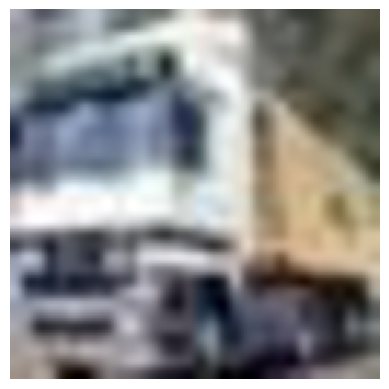

In [50]:
display_image(df.iloc[0]['image'])

#### 2. Test data

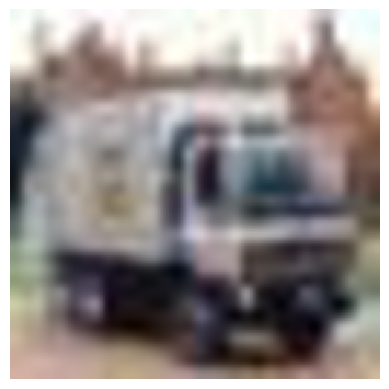

In [51]:
# First image in the test df
display_image(df_test.iloc[0]['image'])

### Data Cleaning: Handling Duplicates, Missing Data, and Corrupted Images

#### 1. Train data

In [52]:
def clean_image_data(df):
    # Hashing
    print("Removing duplicate images...")
    df['img_hash'] = df['image'].apply(lambda img: hashlib.md5(img.tobytes()).hexdigest())
    df.drop_duplicates(subset='img_hash', inplace=True)
    # Drop the hash column after removing duplicates
    df.drop(columns=['img_hash'], inplace=True)  

    # Check for missing labels
    print("Checking for missing labels...")
    missing_labels = df['label'].isnull().sum()
    if missing_labels > 0:
        print(f"Found {missing_labels} missing labels. Dropping rows with missing labels...")
        df.dropna(subset=['label'], inplace=True)

    # Verify images are loaded correctly and not corrupted
    print("Verifying image integrity...")
    valid_images = []
    for i, row in df.iterrows():
        try:
            img = Image.fromarray(row['image'])
            img.verify()  # Is image corrupted
            valid_images.append(True)
        except Exception as e:
            print(f"Corrupted image detected at index {i}: {e}")
            valid_images.append(False)
    
    df = df[valid_images]

    # Reset index after cleaning
    df.reset_index(drop=True, inplace=True)
    
    return df


In [ ]:
# Apply the cleaning function to train df
df_cleaned = clean_image_data(df)

# Display the cleaned train df
print("Cleaned DataFrame:")
print(df_cleaned.head())


Removing duplicate images...


#### 2. Test data

In [ ]:
# Apply the cleaning function to test df
df_test_cleaned = clean_image_data(df_test)

# Display the cleaned test df
print("Cleaned DataFrame:")
print(df_test_cleaned.head())

### EDA

#### 1. Resize and Display Images

In [ ]:
# Get sizes of all images
def get_image_sizes(image_list):
    sizes = [img.shape[:2] for img, _ in image_list]
    return sizes

In [ ]:
sizes = get_image_sizes(all_images)
sizes_df = pd.DataFrame(sizes, columns=['Height', 'Width'])

In [ ]:
# Plot the distribution of image sizes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sizes_df['Height'].hist(bins=30, color='purple', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sizes_df['Width'].hist(bins=30, color='pink', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

According the output above the image size is consistent.

#### 2. Check Class Balance

In [ ]:
# Count occurrences of each label
label_counts = df['label'].value_counts()

# Plot class distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['purple', 'pink'], alpha=0.7)
plt.title('Class Distribution')
plt.xlabel('Label')
plt.ylabel('Number of Images')
plt.xticks(ticks=[0, 1], labels=['REAL', 'FAKE'], rotation=0)
plt.show()

The above show that there is no class imbalance, all the labels have equal number of images

#### 3. Sample Image Visualizations

In [ ]:
def display_images(images, labels, num_images=5, dpi=300):
    plt.figure(figsize=(15, 10), dpi=dpi)  
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])  
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')  
    plt.show()

images_to_display = [df.iloc[i]['image'] for i in range(5)]
labels_to_display = [df.iloc[i]['label'] for i in range(5)]

display_images(images_to_display, labels_to_display, num_images=5, dpi=300)

#### 4. Image Aspect Ratio Distribution

In [ ]:
# Calculate aspect ratios
aspect_ratios = [img.shape[1] / img.shape[0] for img, _ in all_images]

plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=30, color='purple', alpha=0.7)
plt.title('Aspect Ratio Distribution')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.show()

According to the above output the Image Aspet Ratio distribution is consistent throughout the Dataset

#### 5. Analyze Pixel Intensity Distribution

In [ ]:
def get_pixel_intensity_distribution(image_list):
    pixel_values = []
    for img, _ in image_list:
        pixel_values.append(img.mean(axis=(0, 1)))  
    pixel_values = np.array(pixel_values).flatten()  
    return pixel_values

pixel_values = get_pixel_intensity_distribution(all_images)

plt.figure(figsize=(10, 6))
plt.hist(pixel_values, bins=50, color='purple', alpha=0.7)
plt.title('Average Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

The above indicates a balanced range of brightness levels in both real and fake images. This suggests the model will need to focus on complex features like texture and noise, rather than just brightness, to distinguish between real and fake images.

### Modelling

#### 1. Preprocess data

In [ ]:
# Reduce image size to 64x64 to save memory
image_size = (64, 64)

# Convert the images and labels to NumPy arrays and resize images
X_train = np.array([cv2.resize(img, image_size) for img in df['image']], dtype=np.float32)
y_train = np.array([label for label in df['label']], dtype=np.float32)

# Normalize the pixel values to the range 0-1
X_train = X_train / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=2)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### 2. Define CNN model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

#### 3. Train the Model

In [ ]:
history = model.fit(
    X_train, y_train,  
    epochs=10,
    validation_data=(X_val, y_val)  
)

#### 4. Evaluate the Model on Test Data

In [ ]:
# Create an ImageDataGenerator 
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Define the test data generator
test_generator = test_datagen.flow_from_directory(
    'dataset/test',  # Directory where test images are located
    target_size=(64, 64),  # Ensure this matches the input size of your model
    batch_size=32,  # Batch size
    class_mode='categorical',  # Class mode should match how you trained the model
    shuffle=False  # Important to set to False for evaluation
)

In [ ]:
# Evaluate the model 
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

#### 5. Generate Predictions and Confusion Matrix

In [ ]:
# Predict using the test data generator
y_pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
cm


#### 6. Plot the Confusion Matrix

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Purples)
plt.show()

#### 7. Print classification report

In [ ]:
report = classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys())
print("Classification Report:")
print(report)

### Save the model

In [ ]:
model.save('model/cnn_model.h5')  
model.save('model/cnn_deepfake_model.keras')

### Load Trained model

In [ ]:
model = load_model('model/cnn_deepfake_model.keras')

# Load test data 
# Reduce image size to 64x64 to match train data
image_size = (64, 64)
X_test = np.array([cv2.resize(img, image_size) for img in df_test['image']], dtype=np.float32)

# Normalize test data
X_test = X_test / 255.0

# Make predictions
y_test_predictions = model.predict(X_test)
predicted_labels = np.argmax(y_test_predictions, axis=1)  # Get class labels

# Map predictions to readable labels
label_mapping = {0: 'REAL', 1: 'FAKE'}
df_test['PREDICTION'] = predicted_labels
df_test['PREDICTION_LABEL'] = df_test['PREDICTION'].map(label_mapping)


### Save the DataFrame with predictions to a CSV file

In [ ]:
df_test.to_csv('data_pred/deepfake_predictions.csv', index=False)

pred = pd.read_csv('data_pred/deepfake_predictions.csv')
print(pred.head(10))

### Front-End

In [34]:
# Initialize Flask app
app = Flask(__name__, template_folder='public/templates', static_folder='static')

In [35]:
# Load the model
model = load_model('model/cnn_deepfake_model.keras')

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
# Function to preprocess the image
def preprocess_image(image_path):
    image_size = (64, 64)
    img = cv2.imread(image_path)
    img = cv2.resize(img, image_size)
    img = np.array(img, dtype=np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

In [37]:
@app.route('/')
def index():
    return render_template('index.html')

In [38]:
# Set up the directory to save the uploaded files
UPLOAD_FOLDER = 'uploads'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['ALLOWED_EXTENSIONS'] = {'png', 'jpg', 'jpeg'}

In [39]:
def allowed_file(filename):
    return '.' in filename and filename.rsplit('.', 1)[1].lower() in app.config['ALLOWED_EXTENSIONS']

@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'}), 400
    file = request.files['file']
    if file.filename == '':
        return jsonify({'error': 'No selected file'}), 400
    if file and allowed_file(file.filename):
        filename = secure_filename(file.filename)
        file_path = os.path.join(app.config['UPLOAD_FOLDER'], filename)
        file.save(file_path)
        prediction = make_prediction(file_path)
        return jsonify({'prediction': prediction})
    else:
        return jsonify({'error': 'Invalid file format'}), 400

def make_prediction(file_path):
    img = preprocess_image(file_path)
    prediction = model.predict(img)
    
    # Assuming the output is a probability for the "Fake" class
    if prediction[0][1] > 0.5:
        return "Fake"
    else:
        return "Real"

In [40]:
@app.route('/uploads/<filename>')
def uploaded_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

In [41]:
def run_app():
    if not os.path.exists(app.config['UPLOAD_FOLDER']):
        os.makedirs(app.config['UPLOAD_FOLDER'])
    app.run(debug=True, use_reloader=False)

# Run Flask app in a separate thread
thread = Thread(target=run_app)
thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:08:49] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:08:49] "GET /static/banner.jpg HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:08:50] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step


INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:03] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:23] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:38] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:39] "GET /static/banner.jpg HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:39] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:50] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:58] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:58] "GET /static/banner.jpg HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:09:58] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:17:45] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:17:45] "GET /static/banner.jpg HTTP/1.1" 304 -
INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:17:46] "GET / HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:17:58] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:18:03] "POST /predict HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


INFO:werkzeug:127.0.0.1 - - [17/Aug/2024 21:18:15] "POST /predict HTTP/1.1" 200 -
